In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from input_pipeline import dataset_pipeline, get_param_dict, benchmark
from tqdm import tqdm

2023-10-08 12:42:10.547180: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 12:42:10.593388: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 12:42:11.556813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset

In [2]:
path = "../GetData/Rust/get_data_rust/Data/Trainset"

In [3]:
params = get_param_dict(path)
print("Parameters used in this dataset:")
params

Parameters used in this dataset:


{'Steps': '1000',
 'Simulatiton Number': '10000',
 'Temperature': '2.73',
 'Magnetic Field': '0',
 'Mattize Size': '64'}

In [4]:
%%time
dataset = dataset_pipeline(path, batch_size=128)
benchmark(dataset)

Getting data from ../GetData/Rust/get_data_rust/Data/Trainset
Got 10000 samples
Number of examples:  10000
Execution time: 3.2435673069994664
CPU times: user 4.79 s, sys: 1.64 s, total: 6.43 s
Wall time: 3.81 s


# Model

### Restricted Boltzman Machine

In [10]:
class RBM:
    def __init__(self, num_visible, num_hidden, learning_rate):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.W = tf.Variable(tf.random.normal([num_visible, num_hidden]))
        self.visible_bias = tf.Variable(tf.zeros([num_visible]))
        self.hidden_bias = tf.Variable(tf.zeros([num_hidden]))

    def sample_h_given_v(self, v):
        p_h_given_v = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hidden_bias)
        p = tf.random.uniform(shape = p_h_given_v.shape)
        h_new = tf.cast(p_h_given_v <= p, dtype=tf.float32)
        return h_new, p_h_given_v

    def sample_v_given_h(self, h):
        p_v_given_h = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.visible_bias)
        p = tf.random.uniform(shape = p_v_given_h.shape)
        v_new = tf.cast(p_v_given_h <= p, dtype=tf.float32)
        return v_new
    
    def train(self, dataset, num_epochs):
        n = len(dataset)
        for epoch in range(num_epochs):
            reconstruction_loss = 0
            for v0 in tqdm(dataset):
                h0, h0_prob = self.sample_h_given_v(v0)
                v_new = self.sample_v_given_h(h0)
                h_new, h_new_prob = self.sample_h_given_v(v0)
                reconstruction_loss += tf.reduce_mean(tf.square(v0 - v_new))
                self.backward(v0, h0_prob, v_new, h_new_prob)
            print(f"Epoch {epoch}/{num_epochs}, Average Loss: {reconstruction_loss/n:.5f}")
        print("Training completed.")

    def backward(self, v0, h0_prob, v_new, h_new_prob):
        d_vb = tf.reduce_sum(v0, axis=0)-tf.reduce_sum(v_new, axis=0)
        d_hb = tf.reduce_sum(h0_prob, axis=0)-tf.reduce_sum(h_new_prob, axis=0)
        d_W = tf.matmul(tf.transpose(v0), h0_prob) - tf.matmul(tf.transpose(v_new), h_new_prob)
        self.W.assign_add(self.learning_rate * d_W)
        self.hidden_bias.assign_add(self.learning_rate * d_hb)
        self.visible_bias.assign_add(self.learning_rate * d_vb)

    def generate(self, num_samples):
        samples = tf.random.uniform(shape=[num_samples, self.num_visible])
        for _ in range(100):  # Perform 100 Gibbs sampling steps for mixing
            hidden_samples, _ = self.sample_h_given_v(samples)
            samples = self.sample_v_given_h(hidden_samples)
        return samples

In [11]:
rbm = RBM(num_visible=int(params['Mattize Size'])**2, num_hidden=64, learning_rate=0.0001)
rbm.train(dataset, num_epochs=4)

100%|██████████| 79/79 [00:05<00:00, 15.30it/s]


Epoch 0/4, Average Loss: 0.48020


100%|██████████| 79/79 [00:10<00:00,  7.71it/s]


Epoch 1/4, Average Loss: 0.48250


100%|██████████| 79/79 [00:05<00:00, 15.41it/s]


Epoch 2/4, Average Loss: 0.48699


100%|██████████| 79/79 [00:04<00:00, 16.43it/s]

Epoch 3/4, Average Loss: 0.49430
Training completed.


# Compare model to monte carlo algorithm
The goal of this project is to recreate probability distribution of spin configurations in Ising Model using deep learning methods <br>
Below few samples from monte carlo dataset are compared with those created by RBM model. They dont have to be the same as we are sampling randomly but they should<br>
be similar on average.

In [24]:
data_generated = rbm.generate(10)
data_sample = list(dataset.take(1))[0][:10]

In [26]:
def compare_plot(data_sample, data_generated):
    n_rows = len(data_sample)
    fig = plt.figure(constrained_layout=True, figsize=(8, 32))
    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        axs = subfig.subplots(nrows=1, ncols=2)

        axs[0].imshow(tf.reshape(data_generated[index], (64,64)) )
        axs[0].set_title(f'RBM')

        axs[1].imshow(tf.reshape(data_sample[index], (64,64)) )
        axs[1].set_title(f'Monte Carlo')

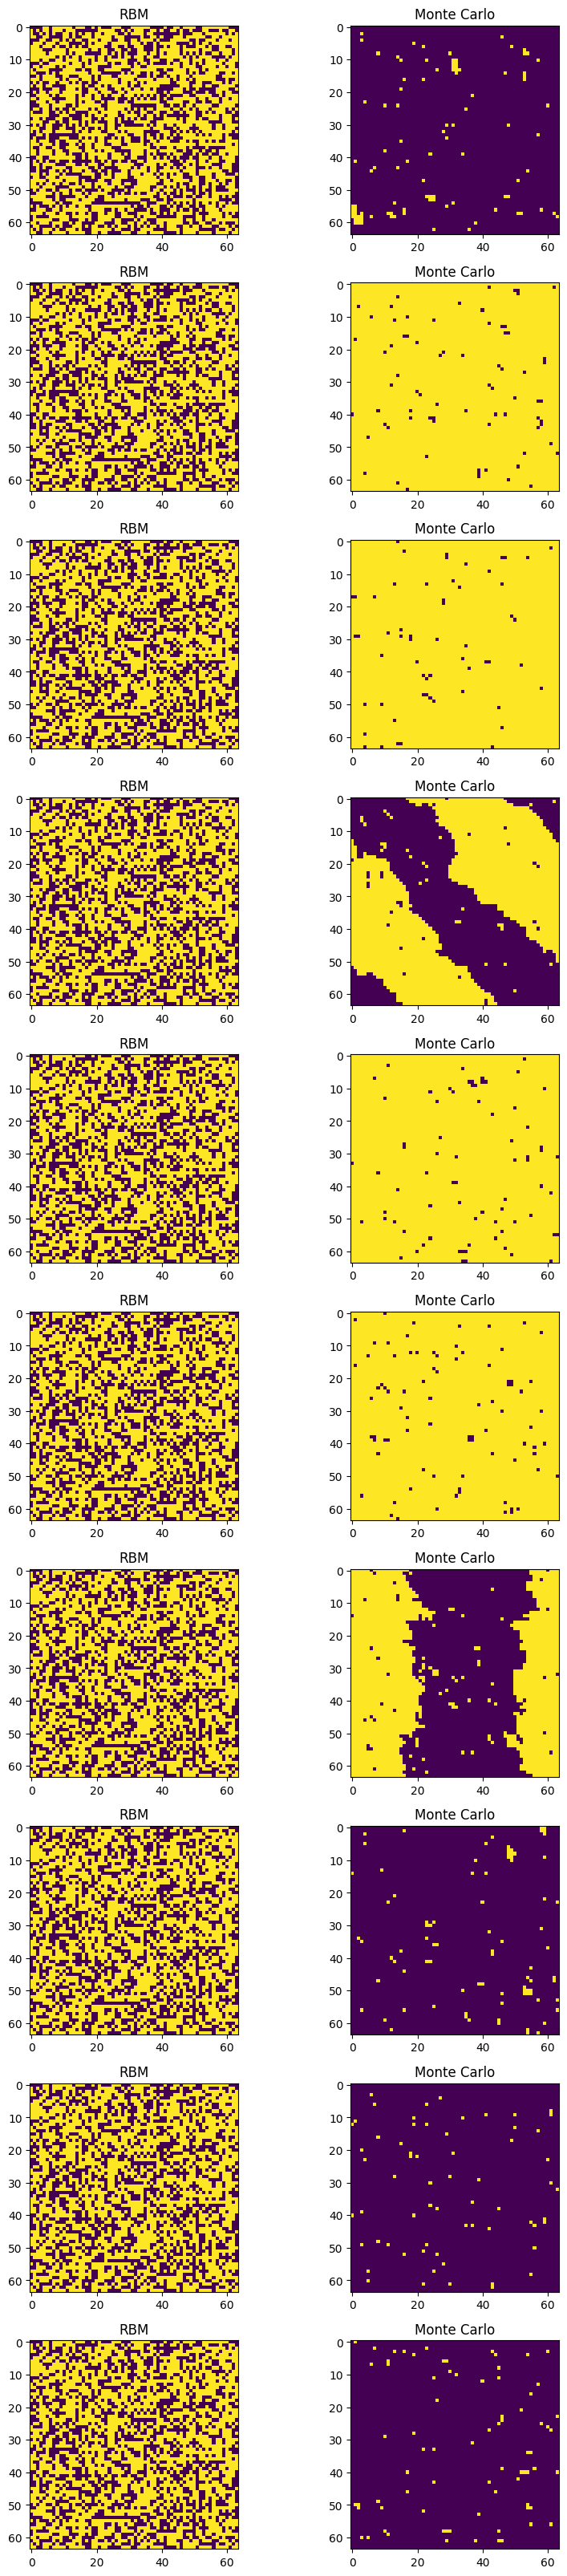

In [27]:
compare_plot(data_sample, data_generated)